In [98]:
from causalgraphicalmodels import CausalGraphicalModel
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col

# Instrumental Variables (IV)

## Intuition of Instrumental Variables

### Canonical IV Dag

To understand the instrumental variables estimator, it is helpful to start with a DAG that shows a chain of causal effects that contains all the information needed to understand the instrumental variables strategy. 

First, notice the backdoor path between $D$ and $Y$: $D \leftarrow U \rightarrow Y$. Furthermore, note that $U$ is unobserved by the econometrician, which causes the backdoor path to remain open. If we have this kind of selection on unobservables, then there does not exist a conditioning strategy that will satisfy the backdoor criterion (in our data). But, before we throw up our arms, let’s look at how $Z$ operates through these pathways.

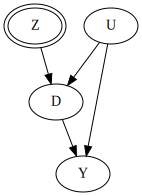

In [20]:
iv = CausalGraphicalModel(nodes = ["Z","D","Y","U"],
                          edges = [("Z","D"),
                                   ("D","Y"),
                                  ("U","D"),
                                  ("U","Y")])
iv = iv.do('Z')
iv.draw()

First, there is a mediated pathway from $Z$ to $Y$ via $D$. When $Z$ varies, $D$ varies, which causes $Y$ to change. But, even though $Y$ is varying when $Z$ varies, notice that $Y$ is only varying **because** $D$ has varied. You sometimes hear people describe this as the “only through” assumption. That is, $Z$ affects $Y$ “**only through**” $D$.

Imagine this for a moment though. Imagine $D$ consists of people making choices. Sometimes these choices affect $Y$, and sometimes these choices are merely correlated with changes in $Y$ due to unobserved changes in $U$. But along comes some shock, $Z$, which induces some but not all of the people in $D$ to make different decisions. What will happen?

Well, for one, when those people’s decisions change, $Y$ will change too, because of the causal effect. But all of the correlation between $D$ and $Y$ in that situation will reflect the causal effect. The reason is that $D$ is a collider along the backdoor path between $Z$ and $Y$.

Moving along, notice that we drew the DAG such that $Z$ is independent of $U$. You can see this because $D$ is a collider along the $Z \rightarrow D \leftarrow U$ path, which implies that $Z$ and $U$ are independent. This is called the “exclusion restriction,” which we will discuss in more detail later. But briefly, the IV estimator assumes that $Z$ is independent of the variables that determine $Y$ except for $D$.

Second, $Z$ is correlated with $D$, and because of its correlation with $D$ (and $D$’s effect on $Y$), $Z$ is correlated with $Y$ but only through its effect on $D$. This relationship between $Z$ and $D$ is called the “first stage” because of the two-stage least squares estimator, which is a kind of IV estimator. The reason it is only correlated with $Y$ via $D$ is because $D$ is a collider along the path $Z \rightarrow D \leftarrow U \rightarrow Y$.

## Applications

### College in the county

We will look at the returns to schooling since it is such a historically popular topic for causal questions in labor. In this application, we will simply estimate a 2SLS model, calculate the first-stage *F statistic*, and compare the 2SLS results with the OLS results.

The data comes from the NLS Young Men Cohort of the National Longitudinal Survey. This data began in 1966 with 5,525 men aged 14–24 and continued to follow up with them through 1981. These data come from 1966, the baseline survey, and there are a number of questions related to local labor-markets. One of them is whether the respondent lives in the same county as a 4-year (and a 2-year) college.

Card (1995) is interested in estimating the following regression equation:

$$ Y_{i} = \alpha + \delta S_{i} + \gamma X_{i} + \epsilon_{i} $$

where $Y$ is log earnings, $S$ is years of schooling, $X$ is a matrix of exogenous covariates, and $\epsilon$ is an error term that contains, among other things, unobserved ability. Under the assumption that  $\epsilon$ contains ability, and ability is correlated with schooling, then $C(S, \epsilon) \neq 0$ and therefore schooling is biased. Card (1995) proposes therefore an instrumental variables strategy whereby he will instrument for schooling with the college-in-the-county dummy variable.

It is worth asking ourselves why the presence of a 4-year college in one’s county would increase schooling. The main reason I can think of is that the presence of the 4-year college increases the likelihood of going to college by lowering the costs, since the student can live at home. This therefore means that we are selecting on a group of compliers whose behavior is affected by the variable. Some kids, in other words, will always go to college regardless of whether a college is in their county, and some will never go despite the presence of the nearby college. But there may exist a group of compliers who go to college only because their county has a college, and if I’m right that this is primarily picking up people going because they can attend while living at home, then it’s necessarily people at some margin who attend only because college became slightly cheaper. This is, in other words, a group of people who are liquidity constrained. And if we believe the returns to schooling for this group are different from those of the always-takers, then our estimates may not represent the ATE. Rather, they would represent the LATE. But in this case, that might actually be an interesting parameter since it gets at the issue of lowering costs of attendance for poorer families.

In [22]:
# load data

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file): 
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)

card = read_data("card.dta")
card.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,...,15.0,NaN,1.0,0.0,16.0,6.306275,256.0,0.198047,6.108228,-3.067539
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,...,35.0,93.0,1.0,1.0,9.0,6.175867,81.0,-0.211160,6.387027,-1.727562
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,...,42.0,103.0,1.0,1.0,16.0,6.580639,256.0,0.204719,6.375920,1.012975
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,...,25.0,88.0,1.0,1.0,10.0,5.521461,100.0,-0.967905,6.489366,-2.253536
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,...,34.0,108.0,1.0,0.0,16.0,6.591674,256.0,0.125173,6.466501,1.090437


In [101]:
#OLS
ols_reg = sm.OLS.from_formula("lwage ~ educ + exper + black + south + married + smsa", 
              data = card).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     219.1
Date:                Wed, 17 Aug 2022   Prob (F-statistic):          1.69e-232
Time:                        23:41:36   Log-Likelihood:                -1278.7
No. Observations:                3010   AIC:                             2571.
Df Residuals:                    3003   BIC:                             2613.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0642      0.064     79.594      0.000       4.939       5.189
educ           0.0711      0.003     20.439      0.000       0.064       0.078
exper          0.0342      0.002     15.459      0.000       0.030       0.039
black         -0.1654      0.018     -9.408      0.000      -0.200      -0.131
south         -0.1325      0.015     -8.855      0.000      -0.162      -0.103
married       -0.0358      0.003    -10.542      0.000      -0.042      -0.029
smsa           0.1751      0.015     11.338      0.000       0.145       0.205
==============================================================================
Omnibus:                       52.534   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.142
Skew:                          -0.231   Prob(JB):                     1.60e-15
Kurtosis:                       3.575   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
# There are null values in the dataset, we will fill them with 0
card['married'] = card['married'].fillna(0)

In [100]:
#2SLS
iv_reg = IV2SLS.from_formula("lwage ~  1 + exper + black + south + married + smsa + [educ ~ nearc4 ]", card).fit()
iv_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  lwage   R-squared:                      0.2428
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2413
No. Observations:                3010   F-statistic:                    884.54
Date:                Wed, Aug 17 2022   P-value (F-stat)                0.0000
Time:                        23:41:32   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      4.0998     0.8209     4.9942     0.0000      2.4909      5.7088
black         -0.1110     0.0493    -2.2504     0.0244     -0.2076     -0.0143
exper          0.0571     0.0195     2.9262     0.0034      0.0189      0.0953
married       -0.0318     0.0050    -6.3846     0.0000     -0.0415     -0.0220
smsa           0.1448     0.0302     4.8025     0.0000      0.0857      0.2039
south         -0.1128     0.0228    -4.9550     0.0000     -0.1574     -0.0682
educ           0.1279     0.0484     2.6438     0.0082      0.0331      0.2227
==============================================================================

Endogenous: educ
Instruments: nearc4
Robust Covariance (Heteroskedastic)
Debiased: False
"""

First, we report our OLS results. For every one year additional of schooling, respondents’ earnings increase by approximately 7.1%. Next we estimated 2SLS. Here we find a much larger return to schooling than we had found using OLS—around 75% larger in fact. The F statistic exceeds 15, suggesting we don’t have a weak instrument problem. The return to schooling associated with this 2SLS estimate is 0.127—that is, for every additional year of schooling, earnings increase by 12.7%. Other covariates are listed if you’re interested in studying them as well.